In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statistics
import time

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve, learning_curve
from sklearn import feature_selection
from sklearn import metrics
from sklearn import kernel_ridge
from sklearn import ensemble
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
import sklearn

In [ ]:
# chargement du dataset
df = pd.read_csv('Data/building-energy-benchmarking.csv', index_col=0)

## les fonctions

In [ ]:
class Chrono(object):  
    def __init__(self):
        self.start()
    def start(self):  
        if hasattr(self, 'interval'):  
            del self.interval  
        self.start_time = time.time()  
  
    def stop(self):  
        if hasattr(self, 'start_time'):  
            self.interval = time.time() - self.start_time  
            del self.start_time # Force timer reinit  
            print('{h}:%.3f temps passé'.format(h = int(self.interval//60)) % (self.interval%60))
            
    def count_stop(self):
        if hasattr(self, 'start_time'):  
            self.interval = time.time() - self.start_time  
            del self.start_time # Force timer reinit  
            return self.interval

In [ ]:
from sklearn.model_selection import GridSearchCV
import timeit
from sklearn import metrics

class Model:
    def __init__(self):
        self.result = pd.DataFrame(columns=[
            'name',
            'params',
            'trainError',
            'testError R2',
            'testError RMSE',
            'learningTime',
            'predictTime'
        ])
        self.best_models = []
    def err(self, model, X, y, scoring):
        """
        Calcul de l'erreur du les prédictions du model
        """
        if scoring == "r2":
            return metrics.r2_score(y, model.predict(X))
        elif scoring == 'neg_root_mean_squared_error':
            return math.sqrt(np.mean((model.predict(X) - y) ** 2))
        else:
            print('scoring invalide')
    def search(self, name, model, params, data, folds=5, verbose=1, scoring="r2"):
        """
        Effectue une recherche par grille sur les paramètres.
        """
        if data:
            X_train = data['X_train']
            y_train = data['y_train']
            X_test = data['X_test']
            y_test = data['y_test']
        
        search = GridSearchCV(model, params, scoring=scoring, verbose=verbose, cv=folds, n_jobs=-1)
        search.fit(X_train, y_train)
        
        self.result = self.result.append({
            'name': name,
            'params': search.best_params_,
            'trainError': self.err(search.best_estimator_, X_train, y_train, scoring),
            'testError R2': self.err(search.best_estimator_, X_test, y_test, 'r2'),
            'testError RMSE': self.err(search.best_estimator_, X_test, y_test, 'neg_root_mean_squared_error'),
            'learningTime': search.refit_time_,
            'predictTime': 0
        }, ignore_index=True)
        
        self.best_models.append(search.best_estimator_)
        print('Résultat ', name,' :')
        print('Paramètres : ', search.best_params_)
        print('Erreur sur le dataset d\'entraînement : ', self.err(search.best_estimator_, X_train, y_train, scoring))
        print('Erreur sur le dataset de test : ', self.err(search.best_estimator_, X_test, y_test, scoring))
        print('Temps d\'apprentissage : ', search.refit_time_)
        
        return search.cv_results_
    def plot(self, name_model, grid, param1, name1, param2, name2):
        try:
            param2
            name2
            test = 1
        except:
            test = 2
        if test == 1:
            fig, ax = plt.subplots(1,1)
            img = ax.imshow(np.log(-np.array(grid['mean_test_score']).reshape(len(param1), len(param2)) + grid['mean_test_score'].max()))
            ax.set_xticklabels(['{:.2e}'.format(x) for x in param2] , Rotation=45, fontdict={
            'horizontalalignment': 'right'})
            ax.set_yticklabels(['{:.2e}'.format(x) for x in param1])
            plt.title(name_model, fontsize =16)
            plt.ylabel(name1, fontsize =14)
            plt.xlabel(name2, fontsize =14)
            plt.show

In [ ]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [ ]:
def perf(model, std=False, exp=False):
    '''
    fait un graphique des performances du modèle par rapport aux vraies données
    '''
    plt.figure(figsize=(10,10))
    ax = plt.subplot()
    if std:
        ax.scatter(model.predict(X_test_std), y_test)
    elif exp:
        ax.scatter(np.exp(model.predict(X_test)), y_test)
    else:
        ax.scatter(model.predict(X_test), y_test)
    add_identity(ax, color='r', ls='--')
    ax.set_aspect('equal')
    plt.show
    if std:
        print('R2 : %3f'%(metrics.r2_score(y_test, model.predict(X_test_std))))
    elif exp:
        print('R2 : %3f'%(metrics.r2_score(y_test, np.exp(model.predict(X_test)))))
    else:
        print('R2 : %3f'%(metrics.r2_score(y_test, model.predict(X_test))))

## Pistes de Modélisation

#### préparatiion des données

In [ ]:
# on crée nos featurs et labels
X = df.drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions(MetricTonsCO2e)', 'SiteEnergyUse(kBtu)Log', 'TotalGHGEmissions(MetricTonsCO2e)Log', 'ENERGYSTARScore'], axis=1)
y = df['TotalGHGEmissions(MetricTonsCO2e)Log']

In [ ]:
# on sépare le trains_set et test_set
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y, test_size=0.2)

In [ ]:
# on standardise les données
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [ ]:
data = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
data_std = {'X_train': X_train_std, 'X_test': X_test_std, 'y_train': y_train, 'y_test': y_test}

In [ ]:
models = Model()

#### baseline

##### régression linéaire

In [ ]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
models.best_models.append(lr)
models.result = models.result.append({
            'name': 'baseline',
            'params': 0,
            'trainError': models.err(lr, X_train, y_train, 'r2'),
            'testError R2': models.err(lr, X_test, y_test, 'r2'),
            'testError RMSE': models.err(lr, X_test, y_test, 'neg_root_mean_squared_error'),
            'predictTime': 0}, ignore_index=True)

#### model lineaire

##### régression Ridge

In [ ]:
n_alphas = 50
alphas = np.logspace(-8, 5, n_alphas)
ridge = models.search('Ridge', linear_model.Ridge(), {'alpha': alphas}, data=data, scoring='r2')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Résultat  Ridge  :
Paramètres :  {'alpha': 0.14563484775012445}
Erreur sur le dataset d'entraînement :  0.5256685593175072
Erreur sur le dataset de test :  0.46258516925274296
Temps d'apprentissage :  0.016016721725463867


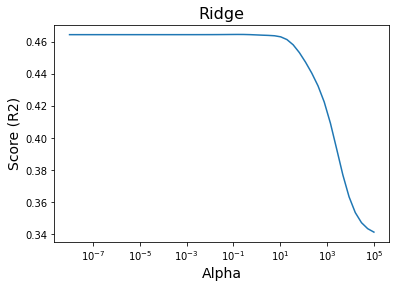

In [ ]:
plt.plot(alphas, ridge['mean_test_score'])
plt.title("Ridge", fontsize=16)
plt.xlabel('Alpha', fontsize=14)
plt.ylabel('Score (R2)', fontsize=14)
plt.xscale('log')

##### régression Elastic Net

In [ ]:
alphas = np.logspace(-7, 4, 15)
ratio = np.linspace(0, 1, 8)
elastic = models.search('Elastic', linear_model.ElasticNet(), {'alpha': alphas, 'l1_ratio': ratio}, data=data, scoring='r2')

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Résultat  Elastic  :
Paramètres :  {'alpha': 0.00013894954943731373, 'l1_ratio': 1.0}
Erreur sur le dataset d'entraînement :  0.5255737597596932
Erreur sur le dataset de test :  0.4591607883569787
Temps d'apprentissage :  0.8273904323577881


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.316e+00, tolerance: 1.040e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log


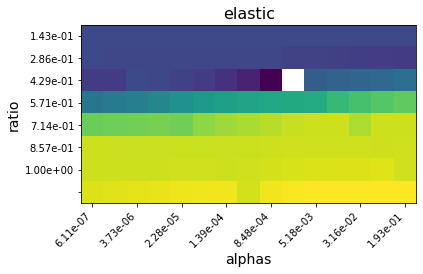

In [ ]:
models.plot('elastic', elastic, ratio, 'ratio', alphas, 'alphas')

#### regression à noyau

In [ ]:
alphas = np.logspace(-5, 2, 10)
gamma = np.logspace(-10, -3, 8)
kernel = models.search('Kernel Ridge', kernel_ridge.KernelRidge(kernel='rbf'), {'alpha': alphas, 'gamma': gamma}, data=data, scoring='r2')

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Résultat  Kernel Ridge  :
Paramètres :  {'alpha': 0.0774263682681127, 'gamma': 1e-10}
Erreur sur le dataset d'entraînement :  0.6234190560139363
Erreur sur le dataset de test :  0.44667471568039785
Temps d'apprentissage :  2.0433108806610107


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log


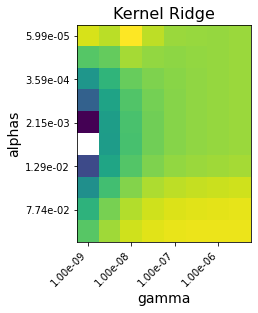

In [ ]:
models.plot('Kernel Ridge', kernel, alphas, 'alphas', gamma, 'gamma')

#### model ensembliste

##### Ada Boost

In [ ]:
n_est = np.round(np.linspace(10, 400, 8)).astype(int)
l_rate = np.logspace(-3, 0, 5)
ada = models.search('AdaBoost', ensemble.AdaBoostRegressor(), {'n_estimators': n_est, 'learning_rate': l_rate}, data=data, folds=3, scoring='r2')

Fitting 3 folds for each of 40 candidates, totalling 120 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Résultat  AdaBoost  :
Paramètres :  {'learning_rate': 0.005623413251903491, 'n_estimators': 344}
Erreur sur le dataset d'entraînement :  0.4910147827600966
Erreur sur le dataset de test :  0.489334175128576
Temps d'apprentissage :  7.931864023208618


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log


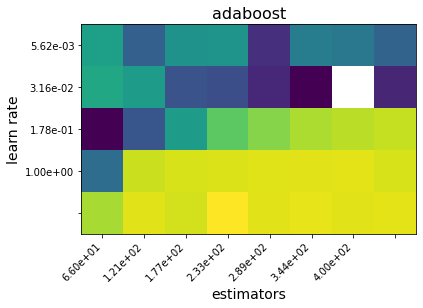

In [ ]:
models.plot('adaboost', ada, l_rate, 'learn rate', n_est, 'estimators')

##### Gradient Boosting

In [ ]:
n_est = np.round(np.linspace(100, 1000, 8)).astype(int)
l_rate = np.logspace(-3, 0, 8)
boost = models.search('Boosting', ensemble.GradientBoostingRegressor(), {'n_estimators': n_est, 'learning_rate': l_rate}, data=data, scoring='r2', folds=3, verbose=2)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Résultat  Boosting  :
Paramètres :  {'learning_rate': 0.13894954943731375, 'n_estimators': 1000}
Erreur sur le dataset d'entraînement :  0.9023747182707444
Erreur sur le dataset de test :  0.7536961125079026
Temps d'apprentissage :  16.20974612236023


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log


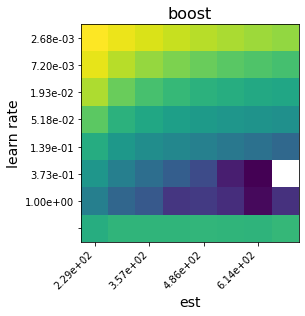

In [ ]:
models.plot('boost', boost, l_rate, 'learn rate', n_est, 'est')

##### Random Forest

In [ ]:
n_est = np.round(np.linspace(100, 1000, 8)).astype(int)
max_dep = np.append(np.round(np.linspace(5, 50, 5)).astype(int), None)
forest = models.search('forest', ensemble.RandomForestRegressor(), {'n_estimators': n_est, 'max_depth': max_dep}, data=data, scoring='r2', verbose=3, folds=3)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Résultat  forest  :
Paramètres :  {'max_depth': 50, 'n_estimators': 486}
Erreur sur le dataset d'entraînement :  0.9741812027793278
Erreur sur le dataset de test :  0.8009984689251964
Temps d'apprentissage :  26.763307809829712


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log


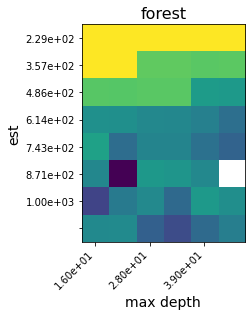

In [ ]:
max_dep[-1] = 60
models.plot('forest', forest, n_est, 'est', max_dep, 'max depth')

### Résumé

In [ ]:
n_repeat = 10
for i,model in enumerate(models.best_models):
    time = timeit.default_timer()
    for j in range(n_repeat):
        model.predict(X)
    time =  timeit.default_timer() - time
    models.result['predictTime'][i] = time / n_repeat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying

In [ ]:
models.result

,name,params,trainError,testError R2,testError RMSE,learningTime,predictTime
0,baseline,0,0.524629,0.481074,1.026192,NaN,0.00509963
1,Ridge,{'alpha': 3.3932217718953296e-08},0.524629,0.481074,1.026192,0.017230,0.00682005
2,Elastic,"{'alpha': 1e-07, 'l1_ratio': 0.0}",0.524629,0.481087,1.026180,0.542988,0.00499864
3,Kernel Ridge,"{'alpha': 0.0774263682681127, 'gamma': 1e-10}",0.623419,0.446675,1.059660,2.043311,0.890072
4,AdaBoost,"{'learning_rate': 0.005623413251903491, 'n_est...",0.491015,0.489334,1.017992,7.931864,0.517571
5,Boosting,"{'learning_rate': 0.13894954943731375, 'n_esti...",0.902375,0.753696,0.706987,16.209746,0.0691218
6,forest,"{'max_depth': 50, 'n_estimators': 486}",0.974181,0.800998,0.635484,26.763308,0.633284


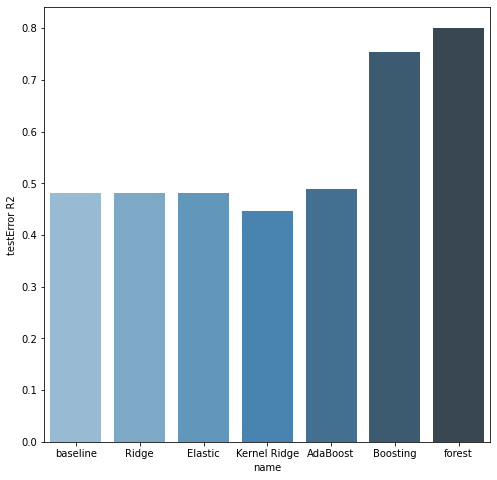

In [ ]:
plt.figure(figsize=(8,8))
sns.barplot(data=models.result, x='name', y='testError R2', palette="Blues_d")

## Modèle Final

### affinage des hyperparamètres

#### Nombre d'Estimateur

In [ ]:
model_forest = ensemble.RandomForestRegressor()
param = {'n_estimators': np.round(np.logspace(1,3,15)).astype(int)}
grid = GridSearchCV(model_forest, param, scoring="r2", cv=5, verbose=2)
grid.fit(X_train, y_train)
result = grid.cv_results_

Text(0, 0.5, "Temps d'apprentissage (seconde)")

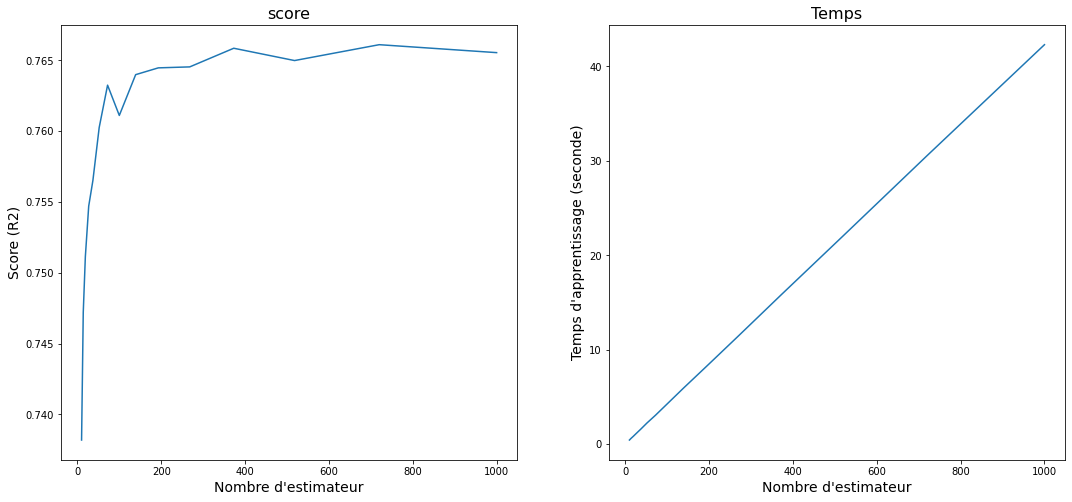

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title("score", fontsize=16)
plt.plot(param['n_estimators'], result['mean_test_score'])
plt.xlabel('Nombre d\'estimateur', fontsize=14)
plt.ylabel('Score (R2)', fontsize=14)
plt.subplot(122)
plt.title("Temps", fontsize=16)
plt.plot(param['n_estimators'], result['mean_fit_time'])
plt.xlabel('Nombre d\'estimateur', fontsize=14)
plt.ylabel('Temps d\'apprentissage (seconde)', fontsize=14)

In [ ]:
model_forest = ensemble.RandomForestRegressor()
param = {'n_estimators': np.round(np.linspace(50, 250, 10)).astype(int)}
grid = GridSearchCV(model_forest, param, scoring="r2", cv=8, verbose=2)
grid.fit(X_train, y_train)
result = grid.cv_results_

In [ ]:
cumul = np.empty((8,10))
for i in range(8):
    cumul[i] = result['split'+str(i)+'_test_score']
cumul = cumul.T

Text(0, 0.5, 'Score (R2)')

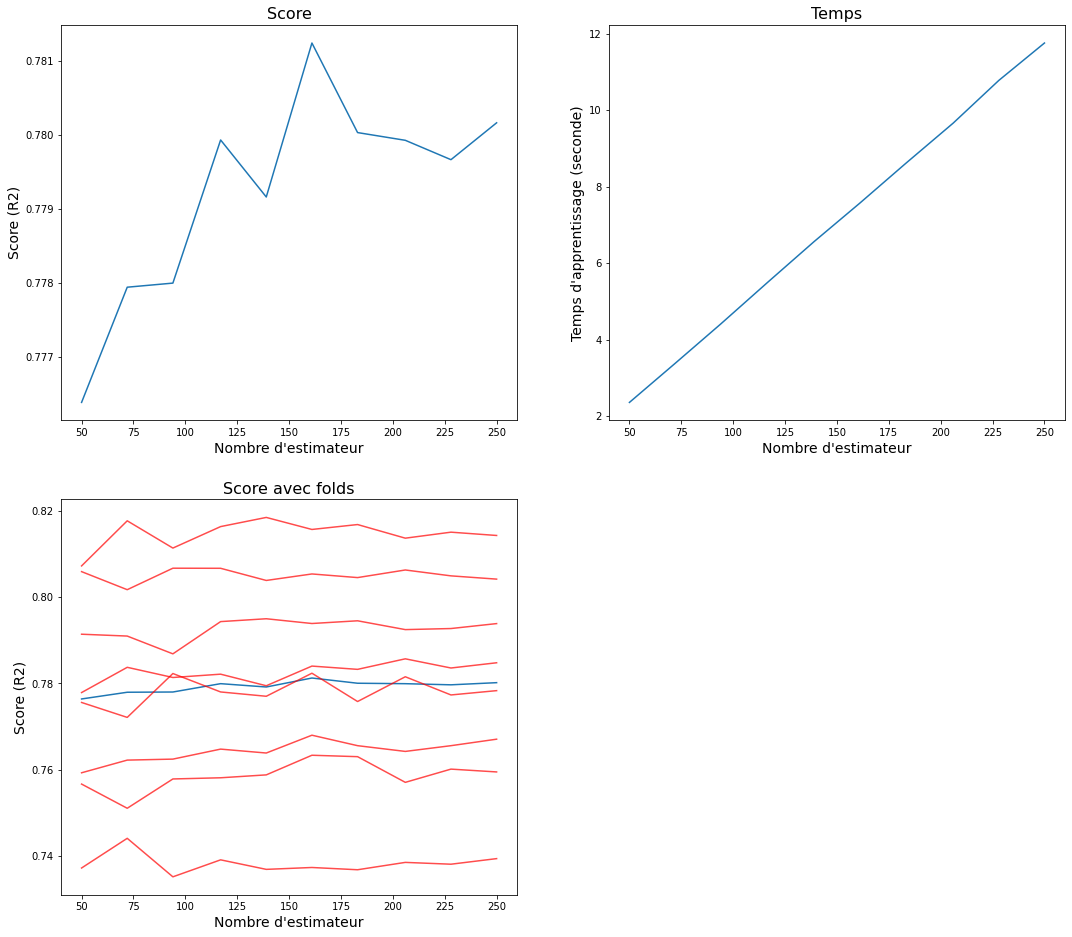

In [ ]:
plt.figure(figsize=(18,16))
plt.subplot(221)
plt.title("Score", fontsize=16)
plt.plot(param['n_estimators'], result['mean_test_score'])
plt.xlabel('Nombre d\'estimateur', fontsize=14)
plt.ylabel('Score (R2)', fontsize=14)
plt.subplot(222)
plt.title("Temps", fontsize=16)
plt.plot(param['n_estimators'], result['mean_fit_time'])
plt.xlabel('Nombre d\'estimateur', fontsize=14)
plt.ylabel('Temps d\'apprentissage (seconde)', fontsize=14)
plt.subplot(223)
plt.title("Score avec folds", fontsize=16)
plt.plot(param['n_estimators'], result['mean_test_score'])
plt.plot(param['n_estimators'], cumul, c='red', alpha = 0.7)
plt.xlabel('Nombre d\'estimateur', fontsize=14)
plt.ylabel('Score (R2)', fontsize=14)

#### Bootstrap et Max Features

In [ ]:
model_forest = ensemble.RandomForestRegressor()
param = {'bootstrap': [True, False], 'max_features': ['sqrt', 'auto', 'log2']}
grid = GridSearchCV(model_forest, param, scoring="r2", cv=5, verbose=2)
grid.fit(X_train, y_train)
result = grid.cv_results_
map = result['mean_test_score'].reshape(2,3)

Text(33.0, 0.5, 'bootstrap')

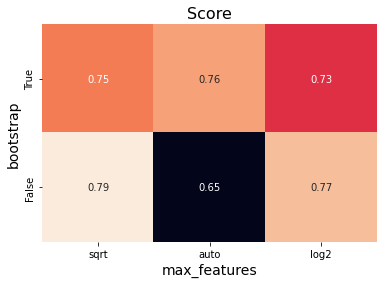

In [ ]:
plt.title("Score", fontsize=16)
sns.heatmap(map, yticklabels=['True', 'False'], xticklabels=['sqrt', 'auto', 'log2'], annot=True, cbar=False)
plt.xlabel('max_features', fontsize=14)
plt.ylabel('bootstrap', fontsize=14)

### Feature selection

In [ ]:
model_feature = ensemble.RandomForestRegressor(bootstrap=False, max_features='sqrt')
model_feature.fit(X_train, y_train)
feature = model_feature.feature_importances_
X_train.loc['sort',:]= feature
X_train.sort_values(by='sort', axis=1, ascending=False, inplace=True)
X_train.drop(['sort'], axis=0, inplace=True)
X_test.loc['sort',:]= feature
X_test.sort_values(by='sort', axis=1, ascending=False, inplace=True)
X_test.drop(['sort'], axis=0, inplace=True)
X.loc['sort',:]= feature
X.sort_values(by='sort', axis=1, ascending=False, inplace=True)
X.drop(['sort'], axis=0, inplace=True)

In [ ]:
# aperçu general
score_test = []
score_train = []
time_spend = []
select_array = []
iter = range(1, X.shape[1]+1)
for i in iter:
    score = model_selection.cross_validate(ensemble.RandomForestRegressor(bootstrap=False, max_features='sqrt'), X_train.iloc[:,:i], y_train, cv=3, scoring='r2', return_train_score=True)
    score_test.append(statistics.mean(score['test_score']))
    score_train.append(statistics.mean(score['train_score']))
    time_spend.append(statistics.mean(score['fit_time']))
    print(X_train.iloc[:,:i].shape[1], '/', len(iter))

<function matplotlib.pyplot.show>

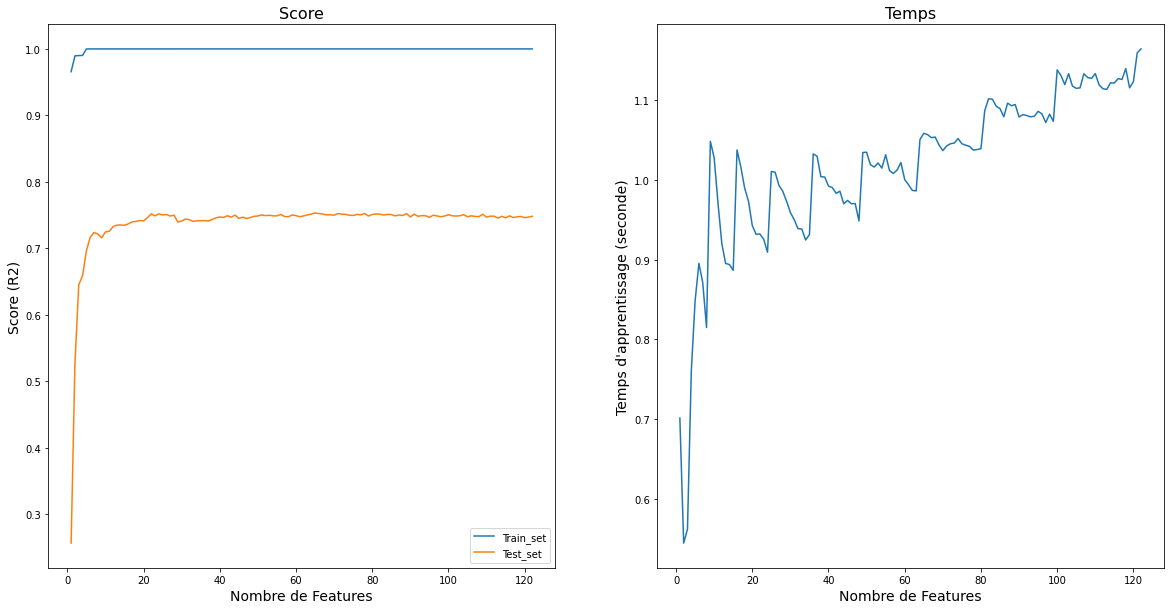

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(iter, score_train)
plt.plot(iter, score_test)
plt.title("Score", fontsize=16)
plt.xlabel('Nombre de Features', fontsize=14)
plt.ylabel('Score (R2)', fontsize=14)
plt.legend(['Train_set', 'Test_set'])
plt.subplot(122)
plt.plot(iter, time_spend)
plt.title("Temps", fontsize=16)
plt.xlabel('Nombre de Features', fontsize=14)
plt.ylabel('Temps d\'apprentissage (seconde)', fontsize=14)
plt.show

<function matplotlib.pyplot.show>

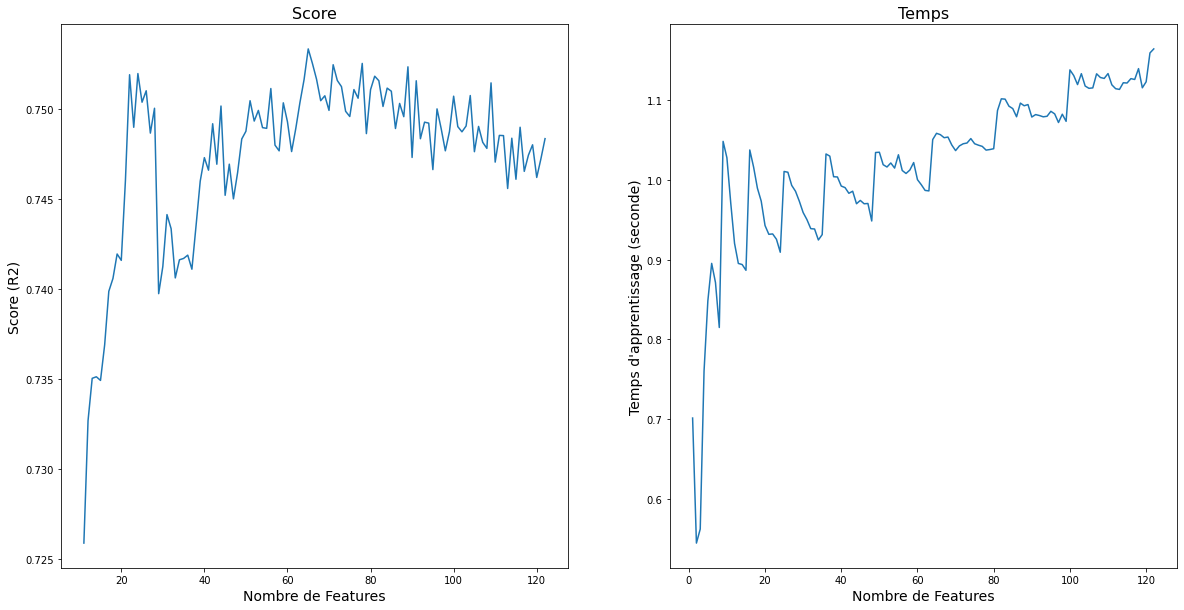

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(iter[10:], score_test[10:])
plt.title("Score", fontsize=16)
plt.xlabel('Nombre de Features', fontsize=14)
plt.ylabel('Score (R2)', fontsize=14)
plt.subplot(122)
plt.plot(iter, time_spend)
plt.title("Temps", fontsize=16)
plt.xlabel('Nombre de Features', fontsize=14)
plt.ylabel('Temps d\'apprentissage (seconde)', fontsize=14)
plt.show

In [ ]:
# plus de précision
score_test = []
select_array = []
cv_score = np.zeros((20,10))
iter = range(10, 30)
for i in iter:
    score = model_selection.cross_validate(ensemble.RandomForestRegressor(bootstrap=False, max_features='sqrt'), X_train.iloc[:,:i], y_train, cv=10, scoring='r2', return_train_score=True)
    score_test.append(statistics.mean(score['test_score']))
    cv_score[i-10] = score['test_score']
    print(i, '/', iter[-1], statistics.mean(score['test_score']))

<function matplotlib.pyplot.show>

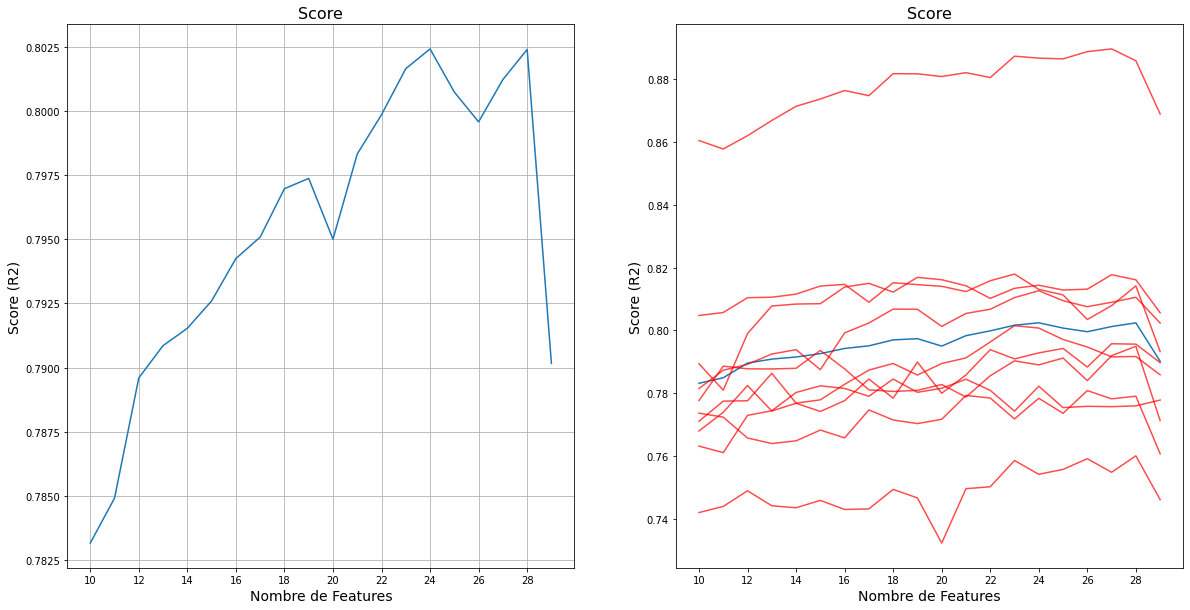

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(iter, score_test)
plt.title("Score", fontsize=16)
plt.xlabel('Nombre de Features', fontsize=14)
plt.ylabel('Score (R2)', fontsize=14)
plt.xticks(range(10,30,2))
plt.grid()
plt.subplot(122)
plt.plot(iter, score_test)
plt.plot(iter, cv_score, c='red', alpha = 0.7)
plt.title("Score", fontsize=16)
plt.xlabel('Nombre de Features', fontsize=14)
plt.ylabel('Score (R2)', fontsize=14)
plt.xticks(range(10,30,2))
plt.show

In [ ]:
X.columns[:20]

Index(['PropertyGFABuilding(s)', 'YearBuilt', 'Multifamily Housing GFA',
       'NumberofFloors', 'Latitude', 'Longitude', 'Parking GFA',
       'Multifamily LR (1-4)', 'PropertyGFAParking', 'Office GFA',
       'Multifamily Housing', 'Non-Refrigerated Warehouse GFA', 'Other GFA',
       'Hotel GFA', 'Retail Store GFA', 'Supermarket/Grocery Store GFA',
       'NonResidential', 'Hospital (General Medical & Surgical) GFA',
       'DOWNTOWN', 'Office'],
      dtype='object')

### Energy Star Score

R2 : 0.868712


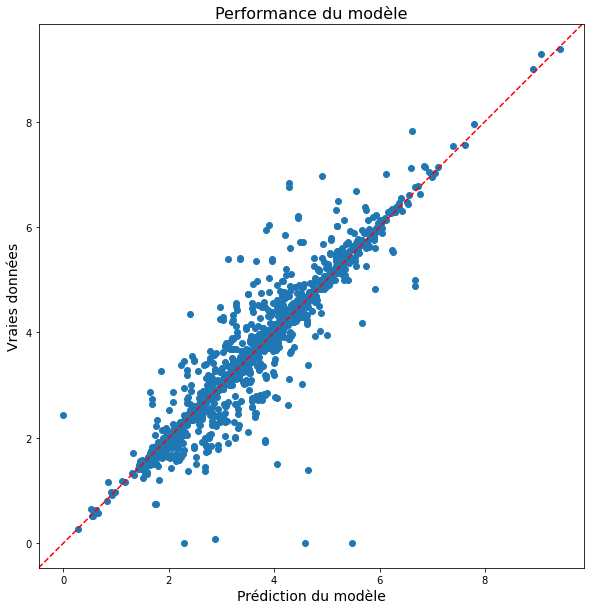

In [ ]:
best_forest = ensemble.RandomForestRegressor(bootstrap=False, max_features='sqrt')
best_forest.fit(X_train.iloc[:,:20], y_train)
plt.figure(figsize=(10,10))
ax = plt.subplot()
ax.scatter(best_forest.predict(X_test.iloc[:,:20]), y_test)
add_identity(ax, color='r', ls='--')
ax.set_aspect('equal')
plt.title("Performance du modèle", fontsize=16)
plt.xlabel('Prédiction du modèle', fontsize=14)
plt.ylabel('Vraies données', fontsize=14)
plt.show
print('R2 : %3f'%(metrics.r2_score(y_test, best_forest.predict(X_test.iloc[:,:20]))))

In [ ]:
X_nostar = X.iloc[:,:20]
X_nostar.insert(0, 'ENERGYSTARScore', df['ENERGYSTARScore'])
X_nostar.insert(0, 'Target', y)
X_nostar.dropna(inplace=True)
y = X_nostar['Target']
X_nostar.drop(['Target'], axis=1, inplace=True)
X_star = X_nostar.copy()
X_nostar.drop(['ENERGYSTARScore'], axis=1, inplace=True)

In [ ]:
score = model_selection.cross_validate(ensemble.RandomForestRegressor(bootstrap=False, max_features='sqrt'), X_star, y, cv=10, scoring='r2')
print('R2 avec ENERGYSTARScore :%f'%statistics.mean(score['test_score']))
score_sans = model_selection.cross_validate(ensemble.RandomForestRegressor(bootstrap=False, max_features='sqrt'), X_nostar, y, cv=10, scoring='r2')
print('R2 sans ENERGYSTARScore :%f'%statistics.mean(score_sans['test_score']))

R2 avec ENERGYSTARScore :0.904252
R2 sans ENERGYSTARScore :0.902550


### Learning Curve

In [ ]:
n_indiv, train, test = model_selection.learning_curve(ensemble.RandomForestRegressor(bootstrap=False, max_features='sqrt'), \
                                                      X_nostar, y, cv=8, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 20), shuffle=True)

Text(0, 0.5, 'Score (R2)')

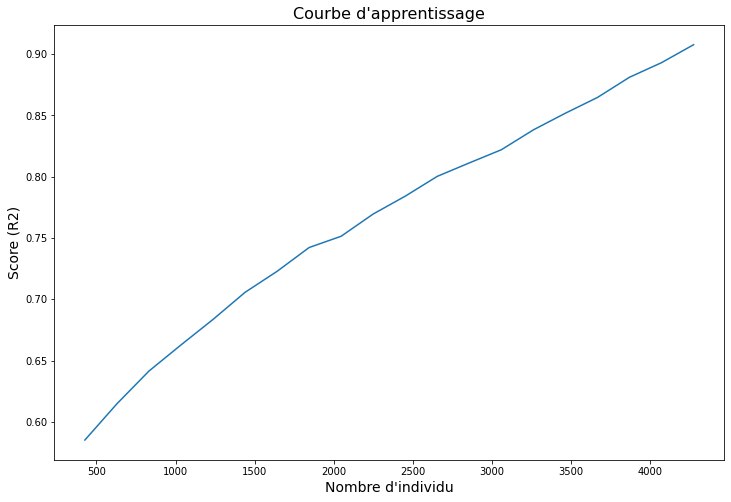

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(n_indiv, test.mean(axis=1))
plt.title("Courbe d'apprentissage", fontsize=16)
plt.xlabel('Nombre d\'individu', fontsize=14)
plt.ylabel('Score (R2)', fontsize=14)